In [1]:
import pickle
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np
import sys
import os
import scipy

import pandas as pd
import csv

# import audio_decryption
import librosa
import IPython.display
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
project_path = '/scratch/yw3004/projects/ICASSP2019-AL/'
data_path = os.path.join(project_path, 'data')

# 1. Load functions for active learning models

In [19]:
def uncertaity_with_moving_threshold(classifier, X_pool, threshold):
    positive_probs = classifier.predict_proba(X_pool)[:,1]

    # for each point, select the maximum uncertainty
    uncertainty = 1-np.abs(threshold - positive_probs)
    return uncertainty

In [20]:
def moving_threshold_sampling(classifier, X_pool, threshold, n_instances=1):
    uncertainty = uncertaity_with_moving_threshold(classifier, X_pool, threshold)
    query_idx = multi_argmax(uncertainty, n_instances=n_instances)
    return query_idx, X_pool[query_idx]

In [21]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [22]:
def get_moving_threshold(cv_round, thresholds, X_val, y_val, iterations=0):
    fmeasures = []
    for threshold in thresholds:
        if iterations == 0:
            model = pickle.load(open(os.path.join(model_path,'model_'+str(cv_round)+'_initial.pickle'), "rb" ))
        else:
            model = pickle.load(open(os.path.join(model_path,'model_'+str(cv_round)+'_'+str(iterations)+'.pickle'), "rb" ))
            
        pred_proba = model.predict_proba(X_val)
        pred = adjusted_classes(pred_proba[:,1], threshold)
        pred = np.array(pred)
        fmeasures.append(f1_score(y_val, pred))
        
    f_measures = np.asarray(fmeasures)  
    fmeasure_best = np.max(f_measures)    
    threshold_best = thresholds[np.argmax(f_measures)]

    return fmeasure_best, threshold_best

# 2. Predicted score distribution #

In [125]:
def pred_score_dist(model_folder, cv_round, n_plot=100):
    X_val = pickle.load(open(os.path.join(data_path, 'X_val_'+str(cv_round)+'.pickle'), "rb" ))
    y_val = pickle.load(open(os.path.join(data_path, 'y_val_'+str(cv_round)+'.pickle'), "rb" ))
    n_val = len(y_val)
    n_pos = n_val//2
    n_neg = n_val//2
    
    true_pos_scores_array = np.zeros((1, n_pos))
    true_neg_scores_array = np.zeros((1, n_neg))
    
    for iteration in range(101):
        if iteration == 0:
            model = pickle.load(open(os.path.join(model_folder, 'model_'+str(cv_round)+'_initial.pickle'), "rb" ))
        else:
            model = pickle.load(open(os.path.join(model_folder, 'model_'+str(cv_round)+'_'+str(iteration)+'.pickle'), "rb" ))
    
        pred_prob = model.predict_proba(X_val)
        y_val_array = y_val.reshape(-1,1)
        score_dist = np.concatenate((pred_prob, y_val_array),axis=1)
    
        true_pos_scores = []
        true_neg_scores = []
        for score in score_dist:
            if score[2] == 1:
                true_pos_scores.append(score[1])
            else:
                true_neg_scores.append(score[1])
        
        true_pos_scores_array = np.vstack((true_pos_scores_array, np.asarray(true_pos_scores)))
        true_neg_scores_array = np.vstack((true_neg_scores_array, np.asarray(true_neg_scores)))
                                
    true_pos_scores_array = np.delete(true_pos_scores_array, (0), axis=0)
    true_neg_scores_array = np.delete(true_neg_scores_array, (0), axis=0)                            
    
    if n_plot == 100:
        fig = plt.figure(figsize=(15,60))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        for i in range(1, 101):
            ax = fig.add_subplot(20, 5, i)
            ax.hist(true_pos_scores_array[i-1], 15, alpha=0.5, edgecolor='k', label='true positives')
            ax.hist(true_neg_scores_array[i-1], 15, alpha=0.5, edgecolor='k', label='true positives')
            ax.set_xlim(0,1)  
            ax.set_title(str(i-1)+ ' iterations')
            ax.set_ylabel('Counts')
    else:
        fig = plt.figure(figsize=(8,5))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        for i in range(1, len(n_plot)+1):
            ax = fig.add_subplot(2, 3, i)
            ax.hist(true_pos_scores_array[n_plot[i-1]], 15, alpha=0.5, edgecolor='k', label='true positives')
            ax.hist(true_neg_scores_array[n_plot[i-1]], 15, alpha=0.5, edgecolor='k', label='true positives')
            ax.set_xlim(0,1) 
            ax.set_title(str(n_plot[i-1])+ ' iterations')
            ax.set_ylabel('Counts')

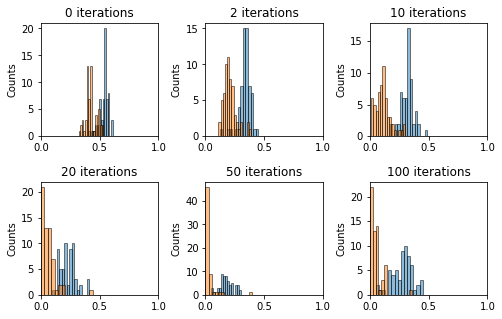

In [126]:
pred_score_dist(os.path.join(project_path, 'models', 'moving_threshold'), 2, n_plot=[0,2,10,20,50,100])

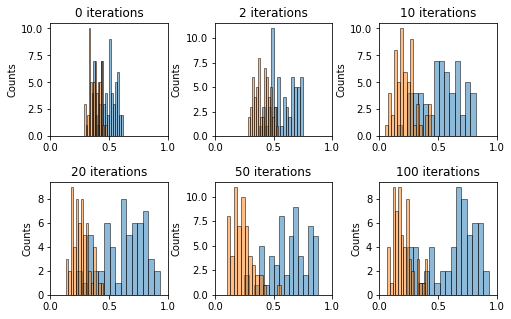

In [127]:
pred_score_dist(os.path.join(project_path, 'models', 'fixed_threshold'), 1, n_plot=[0,2,10,20,50,100])

# 3. Get val performance

## 3.1  For moving threshold

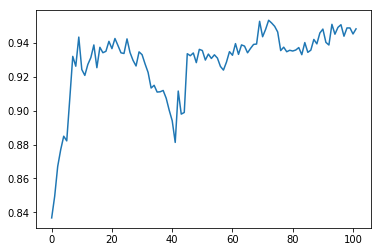

In [114]:
fmeasures_array = np.zeros((1,102))
for cv_round in range(1,6):
    fmeasures = pickle.load(open(os.path.join(project_path, 'evaluation', 'best_fmeasures_'+str(cv_round)+'.pickle'), "rb" ))
    fmeasures = fmeasures[:102]
    fmeasures_array = np.vstack((fmeasures_array, fmeasures))
fmeasures_array = np.delete(fmeasures_array, (0), axis=0) 
mean_fmeasures = np.mean(fmeasures_array, axis=0)
plt.plot(mean_fmeasures)

## 3.2 For fixed threshold

In [132]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [138]:
def get_fmeasure_threshold(thresholds, fulltrain=False, random=False, iterations=0):
    fmeasures_mean  = []
    fmeasures_std = []
    for threshold in thresholds:
        fmeasures = []
        for cv_round in range(1,cv+1):
            if iterations == 0:
                model = pickle.load(open(os.path.join(model_folder,'model_'+str(cv_round)+'_initial.pickle'), "rb" ))
            else:
                model = pickle.load(open(os.path.join(model_folder,'model_'+str(cv_round)+'_'+str(iterations)+'.pickle'), "rb" ))
            
            X_val = pickle.load(open(os.path.join(data_path, 'X_val_'+str(cv_round)+'.pickle'), "rb" ))
            y_val = pickle.load(open(os.path.join(data_path, 'y_val_'+str(cv_round)+'.pickle'), "rb" ))
                    
            pred_proba = model.predict_proba(X_val)
            pred = adjusted_classes(pred_proba[:,1], threshold)
            pred = np.array(pred)
            fmeasures.append(f1_score(y_val, pred))
        
        f_measures = np.asarray(fmeasures)
        fmeasures_mean.append(np.mean(f_measures))
        fmeasures_std.append(np.std(f_measures))
        
    fmeasure_best = np.amax(fmeasures_mean)    
    threshold_best = thresholds[np.argmax(fmeasures_mean)]
    std_best = fmeasures_std[np.argmax(fmeasures_mean)]

    return fmeasure_best, threshold_best, std_best

In [139]:
model_folder = os.path.join(project_path, 'models', 'fixed_threshold')
thresholds = np.arange(0.1,0.9,0.01)

In [140]:
num_iter = 100
cv = 4
fmeasure_bests = []
threshold_bests = [] 
std_bests = []
for i in range(num_iter+1):
    fmeasure_best, threshold_best, std_best = get_fmeasure_threshold(thresholds, iterations=i)
    fmeasure_bests.append(fmeasure_best)
    threshold_bests.append(threshold_best)
    std_bests.append(std_best)

/home/yw3004/miniconda3/envs/active_learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0,0.5,'F1 score')

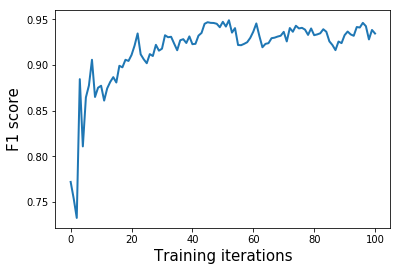

In [159]:
fmeasure_bests = np.array(fmeasure_bests)
threshold_bests = np.array(threshold_bests) 
std_bests = np.array(std_bests)
fig, ax = plt.subplots(1)
array_range = np.arange(101)
ax.plot(array_range, fmeasure_bests, lw=2)
# ax.fill_between(array_range,fmeasure_bests+std_bests, fmeasure_bests-std_bests, facecolor='blue', alpha=0.2)
ax.set_xlabel('Training iterations', fontsize=15)
ax.set_ylabel('F1 score', fontsize=15)

In [142]:
best_fmeasure = max(fmeasure_bests)
best_iter = np.argmax(fmeasure_bests)
best_threshold = threshold_bests[best_iter]
print(best_fmeasure)
print(best_threshold)
print(best_iter)

0.9491228070175439
0.3699999999999999
52


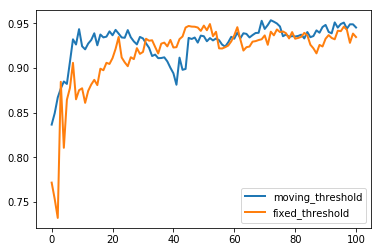

In [168]:
fig, ax = plt.subplots(1)
array_range = np.arange(101)
ax.plot(array_range, mean_fmeasures[:101], lw=2, label='moving_threshold')
ax.plot(array_range, fmeasure_bests, lw=2, label='fixed_threshold')
ax.legend(loc='best')

# 4. Get test performance

In [150]:
def get_test_fmeasure(model_folder, sampling_strategy='uncertainty_sampling'):
    test_fmeasures_array = np.zeros((1,101))
    for cv_round in range(1,6):
        test_fmeasures = []
        thresholds = pickle.load(open(os.path.join(project_path, 'evaluation','moving_threshold', 'best_thresholds_'+str(cv_round)+'.pickle'), "rb" ))

        for iteration in range(101):
            if iteration == 0:
                model = pickle.load(open(os.path.join(model_folder, 'model_'+str(cv_round)+'_initial.pickle'), "rb" ))
            else:
                model = pickle.load(open(os.path.join(model_folder, 'model_'+str(cv_round)+'_'+str(iteration)+'.pickle'), "rb" ))

            X_test = pickle.load(open(os.path.join(data_path, 'X_test_'+str(cv_round)+'.pickle'), "rb" ))
            y_test = pickle.load(open(os.path.join(data_path, 'y_test_'+str(cv_round)+'.pickle'), "rb" ))
        
            pred_proba = model.predict_proba(X_test)
            
            if sampling_strategy == 'moving_threshold':
                pred = adjusted_classes(pred_proba[:,1], thresholds[iteration])
            else:
                pred = adjusted_classes(pred_proba[:,1], best_threshold)
                
            pred = np.array(pred)
            test_fmeasures.append(f1_score(y_test, pred))
            
        test_fmeasures_array = np.vstack((test_fmeasures_array, test_fmeasures))
        
    test_fmeasures_array = np.delete(test_fmeasures_array, (0), axis=0) 
    mean_test_fmeasures = np.mean(test_fmeasures_array, axis=0)
    return mean_test_fmeasures

In [162]:
mean_test_fmeasures_moving = get_test_fmeasure(os.path.join(project_path, 'models', 'moving_threshold'), sampling_strategy='moving_threshold')

In [163]:
mean_test_fmeasures_fixed = get_test_fmeasure(os.path.join(project_path, 'models', 'fixed_threshold'))

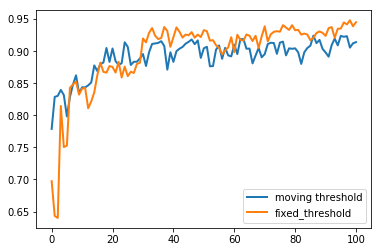

In [166]:
fig, ax = plt.subplots(1)
array_range = np.arange(101)
ax.plot(array_range, mean_test_fmeasures_moving, lw=2, label='moving threshold')
ax.plot(array_range, mean_test_fmeasures_fixed, lw=2, label='fixed_threshold')
ax.legend(loc='best')

# Below needs modification

# 5. F-measure (on val data) at each iteration #

## For models trained with full training data

In [14]:
fmeasure_best_fulltrain, threshold_best_fulltrain, std_best_fulltrain = get_fmeasure_threshold(thresholds, fulltrain=True)

In [15]:
fmeasure_best_fulltrain

0.9736272271369053

In [16]:
threshold_best_fulltrain

0.48999999999999977

In [17]:
std_best_fulltrain

0.008160504804683257

## For random model

In [24]:
cv = 5
num_iter = 100
fmeasure_bests_random = []
threshold_bests_random = [] 
std_bests_random = []
for i in range(num_iter+1):
    fmeasure_best, threshold_best, std_best = get_fmeasure_threshold(thresholds, random=True, iterations=i)
    fmeasure_bests_random.append(fmeasure_best)
    threshold_bests_random.append(threshold_best)
    std_bests_random.append(std_best)

/home/yw3004/miniconda3/envs/active_learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0,0.5,'F1 score')

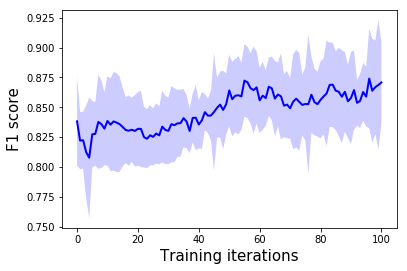

In [25]:
fmeasure_bests_random = np.array(fmeasure_bests_random)
threshold_bests_random = np.array(threshold_bests_random) 
std_bests_random = np.array(std_bests_random)
array_range = np.arange(101)
fig, ax = plt.subplots(1)
ax.plot(array_range, fmeasure_bests_random, lw=2, color='blue')
ax.fill_between(array_range,fmeasure_bests_random+std_bests_random, fmeasure_bests_random-std_bests_random, facecolor='blue', alpha=0.2)
ax.set_xlabel('Training iterations', fontsize=15)
ax.set_ylabel('F1 score', fontsize=15)

In [26]:
best_fmeasure_random = max(fmeasure_bests_random)
best_iter_random = np.argmax(fmeasure_bests_random)
best_threshold_random = threshold_bests[best_iter_random]
print(best_fmeasure_random)
print(best_threshold_random)
print(best_iter_random)

0.8740055992495834
0.47999999999999976
96


(0.65, 1)

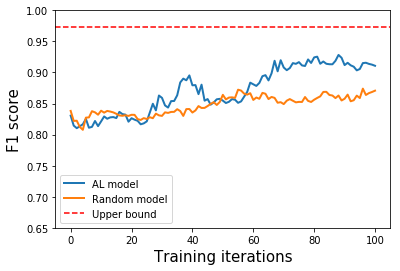

In [31]:
fig, ax = plt.subplots(1)
ax.plot(array_range, fmeasure_bests, lw=2, label='AL model')
# ax.fill_between(array_range,fmeasure_bests+std_bests, fmeasure_bests-std_bests, alpha=0.1)
ax.plot(array_range, fmeasure_bests_random, lw=2, label='Random model')
# ax.fill_between(array_range,fmeasure_bests_random+std_bests_random, fmeasure_bests_random-std_bests_random, alpha=0.1)
# ax2 = ax.twinx()
# ax2.plot(array_range, mid_diffs_mean, lw=2, color='orange')
# ax2.fill_between(array_range,mid_diffs_mean+mid_diffs_std, mid_diffs_mean-mid_diffs_std, facecolor='orange', alpha=0.1)
plt.axhline(y=fmeasure_best_fulltrain, color='r', linestyle='--', label='Upper bound')
ax.legend(loc='best')
ax.set_xlabel('Training iterations', fontsize=15)
ax.set_ylabel('F1 score', fontsize=15)
ax.set_ylim(0.65,1)

# 4. Load model for test#

## For model trained on full training data

In [33]:
model_fulltraining = pickle.load(open(os.path.join(model_folder,inst+'_model_training_full.pickle'), "rb" ))
test_pred_prob_full = model_fulltraining.predict_proba(X_test)
test_pred_full = adjusted_classes(test_pred_prob_full[:,1],threshold_best_fulltrain)
test_precision_full = precision_score(y_test, test_pred_full)
test_recall_full = recall_score(y_test, test_pred_full)
test_fmeasure_full = f1_score(y_test, test_pred_full)
test_confusion_matrices_full = confusion_matrix(y_test, test_pred_full)
print(test_precision_full)
print(test_recall_full)
print(test_fmeasure_full)
print(test_confusion_matrices_full)

0.9523809523809523
0.9893992932862191
0.9705372616984402
[[134  14]
 [  3 280]]


## For models trained with AL

In [34]:
test_precisions = []
test_recalls = []
test_fmeasures = []
model = pickle.load(open(os.path.join(model_folder,'model_initial.pickle'), "rb" ))
test_pred_prob = model.predict_proba(X_test)
test_pred = adjusted_classes(test_pred_prob[:,1], best_threshold)
test_precisions.append(precision_score(y_test, test_pred))
test_recalls.append(recall_score(y_test, test_pred))
test_fmeasures.append(f1_score(y_test, test_pred))
for i in range(1, num_iter+1):
    model = pickle.load(open(os.path.join(model_folder,inst+'_model_test_iter_'+str(i)+'.pickle'), "rb" ))
    test_pred_prob = model.predict_proba(X_test)
    test_pred = adjusted_classes(test_pred_prob[:,1], best_threshold)
    test_precisions.append(precision_score(y_test, test_pred))
    test_recalls.append(recall_score(y_test, test_pred))
    test_fmeasures.append(f1_score(y_test, test_pred))

In [35]:
test_fmeasures[0]

0.7954866008462623

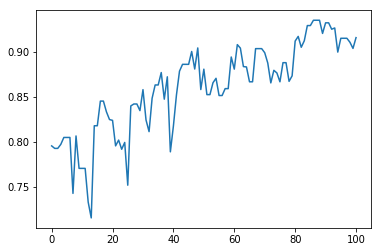

In [36]:
plt.plot(test_fmeasures)

## For random models

In [37]:
test_precisions_random = []
test_recalls_random  = []
test_fmeasures_random  = []
model = pickle.load(open(os.path.join(model_folder,inst+'_model_test_initial.pickle'), "rb" ))
test_pred_prob = model.predict_proba(X_test)
test_pred = adjusted_classes(test_pred_prob[:,1], best_threshold_random)
test_precisions_random .append(precision_score(y_test, test_pred))
test_recalls_random .append(recall_score(y_test, test_pred))
test_fmeasures_random .append(f1_score(y_test, test_pred))
for i in range(1, num_iter+1):
    model = pickle.load(open(os.path.join(model_folder,inst+'_model_random_test_iter_'+str(i)+'_.pickle'), "rb" ))
    test_pred_prob = model.predict_proba(X_test)
    test_pred = adjusted_classes(test_pred_prob[:,1], best_threshold_random)
    test_precisions_random .append(precision_score(y_test, test_pred))
    test_recalls_random .append(recall_score(y_test, test_pred))
    test_fmeasures_random .append(f1_score(y_test, test_pred))

/home/yw3004/miniconda3/envs/active_learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yw3004/miniconda3/envs/active_learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


([<matplotlib.axis.YTick at 0x2aad5d3a0e48>,
 <a list of 11 Text yticklabel objects>)

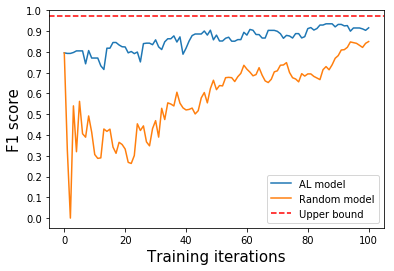

In [38]:
plt.plot(test_fmeasures, label='AL model')
plt.plot(test_fmeasures_random, label='Random model')
plt.axhline(y=test_fmeasure_full, color='r', linestyle='--', label='Upper bound')
plt.legend(loc='best')
plt.xlabel('Training iterations', fontsize=15)
plt.ylabel('F1 score', fontsize=15)
plt.yticks(np.arange(0,1.1,0.1))

In [74]:
test_fmeasures_best = max(test_fmeasures)
test_iter_best = np.argmax(test_fmeasures)
print(test_fmeasures_best)
print(test_iter_best)
print(test_fmeasures_random[86])

0.935251798561151
86
0.7292576419213972


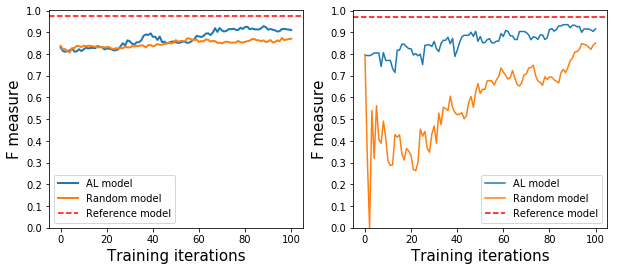

In [52]:
fig, ((ax1),(ax2)) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(array_range, fmeasure_bests, lw=2, label='AL model')
ax1.plot(array_range, fmeasure_bests_random, lw=2, label='Random model')
ax1.axhline(y=fmeasure_best_fulltrain, color='r', linestyle='--', label='Reference model')
ax1.legend(loc='best')
ax1.set_xlabel('Training iterations', fontsize=15)
ax1.set_ylabel('F measure', fontsize=15)
ax1.set_ylim(0,1.001)
ax1.set_yticks(np.arange(0,1.001,0.1))
ax2.plot(test_fmeasures, label='AL model')
ax2.plot(test_fmeasures_random, label='Random model')
ax2.axhline(y=test_fmeasure_full, color='r', linestyle='--', label='Reference model')
ax2.legend(loc='best')
ax2.set_xlabel('Training iterations', fontsize=15)
ax2.set_ylabel('F measure', fontsize=15)
ax2.set_ylim(0,1.001)
ax2.set_yticks(np.arange(0,1.001,0.1))

## Test prediction distribution, precision/recall

In [42]:
test_pred_prob = best_model.predict_proba(X_test)
# test_pred_prob = model_random.predict_proba(x_test)
y_test_ = y_test.reshape(-1,1)
test_score_dist = np.concatenate((test_pred_prob, y_test_),axis=1)

In [43]:
true_pos_scores = []
true_neg_scores = []
for score in test_score_dist:
    if score[2] == 1:
        true_pos_scores.append(score[1])
    else:
        true_neg_scores.append(score[1])

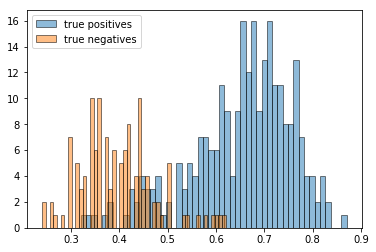

In [44]:
plt.hist(true_pos_scores,50, alpha=0.5, edgecolor='k', label='true positives')
plt.hist(true_neg_scores,50, alpha=0.5, edgecolor='k', label='true negatives')
plt.legend(loc='best')

In [45]:
test_pred = adjusted_classes(test_pred_prob[:,1], best_threshold)
test_precision = precision_score(y_test, test_pred)
test_recall = recall_score(y_test, test_pred)
test_confusion_matrices = confusion_matrix(y_test, test_pred)
print(test_precision)
print(test_recall)
print(test_confusion_matrices)

0.966804979253112
0.8893129770992366
[[117   8]
 [ 29 233]]


# 5. Get misclassified samples

In [41]:
with open(os.path.join(path_project,'mean_feat_vggish_openmic.pickle'), 'rb') as f:
    mean_feat = pickle.load(f, encoding='latin1')

In [46]:
X_test_mean = X_test[0][:128]

In [90]:
list(mean_feat.values())

In [52]:
def load_misclassified(model, X_test, y_test, threshold):
    test_pred_prob = model.predict_proba(X_test)
    test_pred = adjusted_classes(test_pred_prob[:,1], threshold)
    misclassified = np.where(y_test != test_pred)[0]
    for idx in misclassified:
        print(test_pred_prob[idx])
        print(y_test[idx])
        
        X_test_mean = X_test[idx]
        print(X_test_mean)
#         key = list(mean_feat.keys())[list(mean_feat.values()).index(X_test_mean)]
#         print(key)
        
#         filepath = os.path.join(path_project, 'fma-audio', str(key) +'.ogg')
#         y_track, sr = librosa.core.load(filepath)
#         IPython.display.display(IPython.display.Audio(data=y_track, rate=sr))

In [91]:
load_misclassified(best_model, X_test, y_test, best_threshold)

## Need modification

# 6. Draw random training data for comparison #

In [66]:
cv_round = 5

In [67]:
X_train = pickle.load(open(os.path.join(path_project, 'training_data', inst + '_X_train_'+str(cv_round)+'.pickle'), "rb" ))
y_train = pickle.load(open(os.path.join(path_project, 'training_data', inst + '_y_train_'+str(cv_round)+'.pickle'), "rb" ))
X_val = pickle.load(open(os.path.join(path_project, 'training_data', inst + '_X_val_'+str(cv_round)+'.pickle'), "rb" ))
y_val = pickle.load(open(os.path.join(path_project, 'training_data', inst + '_y_val_'+str(cv_round)+'.pickle'), "rb" ))
X_pool = pickle.load(open(os.path.join(path_project, 'training_data', inst + '_X_pool_'+str(cv_round)+'.pickle'), "rb" ))
key_pool = pickle.load(open(os.path.join(path_project, 'training_data', inst + '_key_pool_'+str(cv_round)+'.pickle'), "rb" ))

In [70]:
y_train;

In [69]:
X_train = X_train[-22:-20]
y_train = y_train[-22:-20]
y_train

array([1., 0.])

In [59]:
with open(os.path.join(path_project, 'training_data',inst+ '_X_train_random_'+str(cv_round)+'.pickle'), 'wb') as f:
            pickle.dump(X_train, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(path_project, 'training_data',inst+ '_y_train_random_'+str(cv_round)+'.pickle'), 'wb') as f:
            pickle.dump(y_train, f, protocol=pickle.HIGHEST_PROTOCOL)

## For testing

In [155]:
X_train = pickle.load(open(os.path.join(path_project, 'training_data', inst + '_X_training_full.pickle'), "rb" ))
y_train = pickle.load(open(os.path.join(path_project, 'training_data', inst + '_y_training_full.pickle'), "rb" ))
X_test = pickle.load(open(os.path.join(path_project, 'training_data', inst + '_X_test.pickle'), "rb" ))
y_test = pickle.load(open(os.path.join(path_project, 'training_data', inst + '_y_test.pickle'), "rb" ))
X_pool = pickle.load(open(os.path.join(path_project, 'training_data', inst + '_X_pool.pickle'), "rb" ))
key_pool = pickle.load(open(os.path.join(path_project, 'training_data', inst + '_key_pool.pickle'), "rb" ))

In [156]:
X_train = X_train[203:205]
y_train = y_train[203:205]
y_train

array([0., 1.])

In [157]:
with open(os.path.join(path_project, 'training_data',inst+ '_X_train_random_test_initial.pickle'), 'wb') as f:
            pickle.dump(X_train, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(path_project, 'training_data',inst+ '_y_train_random_test_initial.pickle'), 'wb') as f:
            pickle.dump(y_train, f, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
idx = list(range(0,X_pool.shape[0]))
random.shuffle(idx)
idx = idx[:100]
for i in range(len(idx)):
    X_train = np.vstack((X_train, X_pool[idx[i]]))
    key = key_pool[idx[i]][0]
    filepath = os.path.join(path_project, 'fma-audio', str(key) +'.ogg')
            
    y_track, sr = librosa.core.load(filepath)
    IPython.display.display(IPython.display.Audio(data=y_track, rate=sr))
             
    label = input("Please input label for\nsample_key = '%s' (1 if inst is present, 0 if inst is not present)" % (key))
    y_train = np.concatenate((y_train,[int(label)]))
    
    clf = RandomForestClassifier(max_depth=8, random_state=0, n_estimators=100)
    clf.fit(X_train, y_train)
    
    with open(os.path.join(path_project, 'models', inst+'_model_random_test_iter_'+str(i+1)+'_.pickle'), 'wb') as f:
        pickle.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL) 

In [49]:
y_train.shape
y_train = np.ravel(y_train)

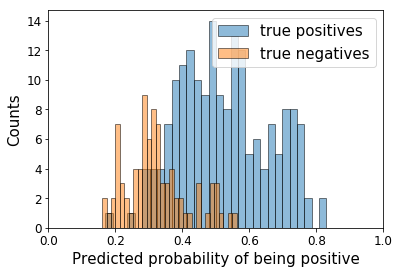

In [51]:
pred_score_dist(os.path.join(model_folder, inst+'_model_random.pickle'))

In [52]:
model_random = pickle.load(open(os.path.join(model_folder, inst+'_model_random.pickle'), "rb" ))

In [53]:
thresholds = np.arange(0.1,0.9,0.01)
f,t = get_fmeasure_threshold(model_random, thresholds)

/home/yw3004/miniconda3/envs/active_learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
t

0.3599999999999999

In [55]:
test_pred_prob_random = model_random.predict_proba(X_test)
test_score_dist = np.concatenate((test_pred_prob_random, y_test_),axis=1)

In [56]:
test_pred_random = adjusted_classes(test_pred_prob_random[:,1], t)
test_precision_random = precision_score(y_test, test_pred_random)
test_recall_random = recall_score(y_test, test_pred_random)
test_confusion_matrices_random = confusion_matrix(y_test, test_pred_random)
print(test_precision_random)
print(test_recall_random)
print(test_confusion_matrices_random)

0.8674242424242424
0.8740458015267175
[[ 90  35]
 [ 33 229]]
